In [1]:
import os
import ee
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
cwd = "c:\\Users\\m1865\\Desktop\\DISC"
cwd_Images_Raw = cwd + "\\Sentinel-2 Images Raw"
cwd_Images_Processed = cwd + "\\Sentinel-2 Images Processed"

In [3]:
# Create a project called "ee-sentinel-2temporal-nir"
# Google Account is jiawei.gao.polimi@gmail.com
ee.Authenticate(force = False)
ee.Initialize(project='ee-sentinel-2temporal-nir')

In [4]:
date_Start = "2023-01-01"
date_End = "2023-12-31"
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [5]:
# Read the spatial bounding box (30m)
gdf = gpd.read_file(cwd_Images_Processed + "\\San Rossore\\30m.shp")
gdf = gdf.to_crs("EPSG:4326")
bounds = gdf.bounds.values.reshape(-1)
roi = ee.Geometry.Rectangle([bounds[0],bounds[1],bounds[2],bounds[3]])

In [6]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [7]:
# s2_sr_cld_col_eval = get_s2_sr_cld_col(roi, date_Start, date_End)

In [8]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

In [9]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

In [10]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

In [11]:
# Import the folium library.
import folium

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [12]:
def display_cloud_layers(col):
    # Mosaic the image collection.
    img = col.mosaic()

    # Subset layers and prepare them for display.
    clouds = img.select('clouds').selfMask()
    shadows = img.select('shadows').selfMask()
    dark_pixels = img.select('dark_pixels').selfMask()
    probability = img.select('probability')
    cloudmask = img.select('cloudmask').selfMask()
    cloud_transform = img.select('cloud_transform')

    # Create a folium map object.
    center = roi.centroid(10).coordinates().reverse().getInfo()
    m = folium.Map(location=center, zoom_start=12)

    # Add layers to the folium map.
    m.add_ee_layer(img,
                   {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                   'S2 image', True, 1, 9)
    m.add_ee_layer(probability,
                   {'min': 0, 'max': 100},
                   'probability (cloud)', False, 1, 9)
    m.add_ee_layer(clouds,
                   {'palette': 'e056fd'},
                   'clouds', False, 1, 9)
    m.add_ee_layer(cloud_transform,
                   {'min': 0, 'max': 1, 'palette': ['white', 'black']},
                   'cloud_transform', False, 1, 9)
    m.add_ee_layer(dark_pixels,
                   {'palette': 'orange'},
                   'dark_pixels', False, 1, 9)
    m.add_ee_layer(shadows, {'palette': 'yellow'},
                   'shadows', False, 1, 9)
    m.add_ee_layer(cloudmask, {'palette': 'orange'},
                   'cloudmask', True, 0.5, 9)

    # Add a layer control panel to the map.
    m.add_child(folium.LayerControl())

    # Display the map.
    display(m)

In [13]:
# s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(add_cld_shdw_mask)

In [14]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [15]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms').dt.date

    # Keep the columns of interest.
    df = df[['datetime',  *list_of_bands]]

    return df

In [19]:
df = pd.read_csv(cwd + "\\Site.csv")
for i in range(df.shape[0]):
    name_Site = df.loc[i,'Site']
    gdf = gpd.read_file(cwd_Images_Processed + "\\" + name_Site + "\\30m.shp")
    gdf = gdf.to_crs("EPSG:4326")
    bounds = gdf.bounds.values.reshape(-1)
    roi = ee.Geometry.Rectangle([bounds[0],bounds[1],bounds[2],bounds[3]])
    s2_sr_cld_col = get_s2_sr_cld_col(roi, date_Start, date_End)
    s2_sr = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask))
    s2_sr_Info = s2_sr.getRegion(roi,10).getInfo()
    s2_RoI_B8 = ee_array_to_df(s2_sr_Info,["B4",'B8'])
    s2_RoI_B8['NDVI'] = (s2_RoI_B8['B8'] - s2_RoI_B8['B4']) / (s2_RoI_B8['B8'] + s2_RoI_B8['B4'])
    s2_RoI_B8.sort_values('datetime')
    df_Merge_Mean = s2_RoI_B8.groupby("datetime").mean().reset_index(drop = False)  
    plt.figure(figsize = (20,10))
    plt.title(f"{name_Site} (30m Average) Near Infrared Values of Sentinel-2 Images in 2023")
    plt.plot(df_Merge_Mean['datetime'], df_Merge_Mean['B8'], label = "NIR")
    plt.legend()
    plt.grid()
    plt.savefig(cwd_Images_Processed + "\\" + name_Site + "\\TimeSeries - NIR.png")
    plt.close()
    plt.figure(figsize = (20,10))
    plt.title(f"{name_Site} (30m Average) NDVI of Sentinel-2 Images in 2023")
    plt.plot(df_Merge_Mean['datetime'], df_Merge_Mean['NDVI'], label = "NDVI")
    plt.legend()
    plt.grid()
    plt.savefig(cwd_Images_Processed + "\\" + name_Site + "\\TimeSeries - NDVI.png")
    plt.close()

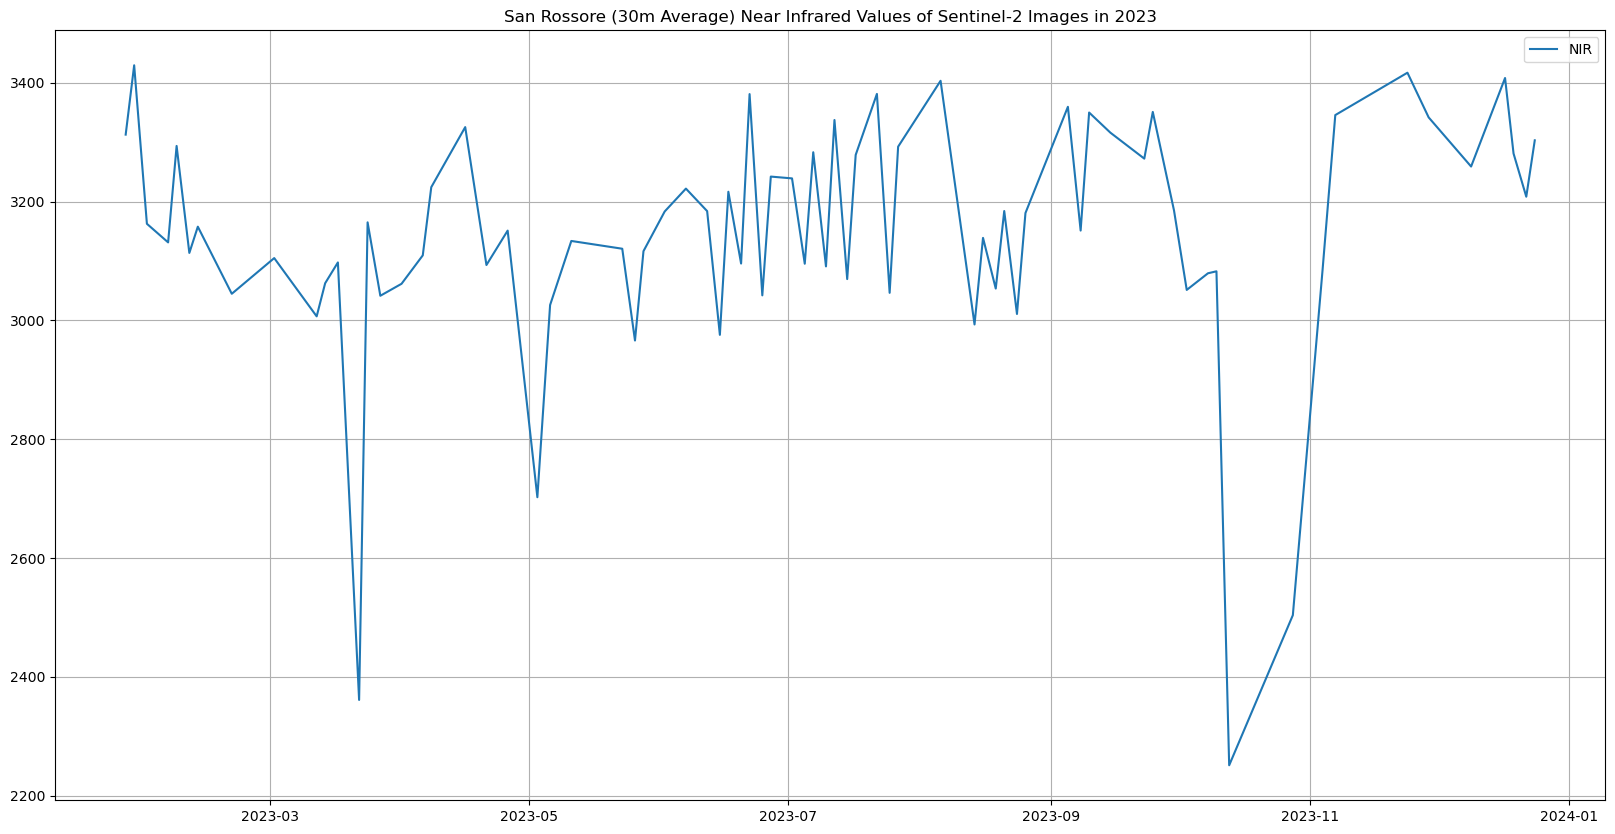

In [32]:
plt.figure(figsize = (20,10))
plt.title("San Rossore (30m Average) Near Infrared Values of Sentinel-2 Images in 2023")
plt.plot(df_Merge_Mean['datetime'], df_Merge_Mean['B8'], label = "NIR")
plt.legend()
plt.grid()

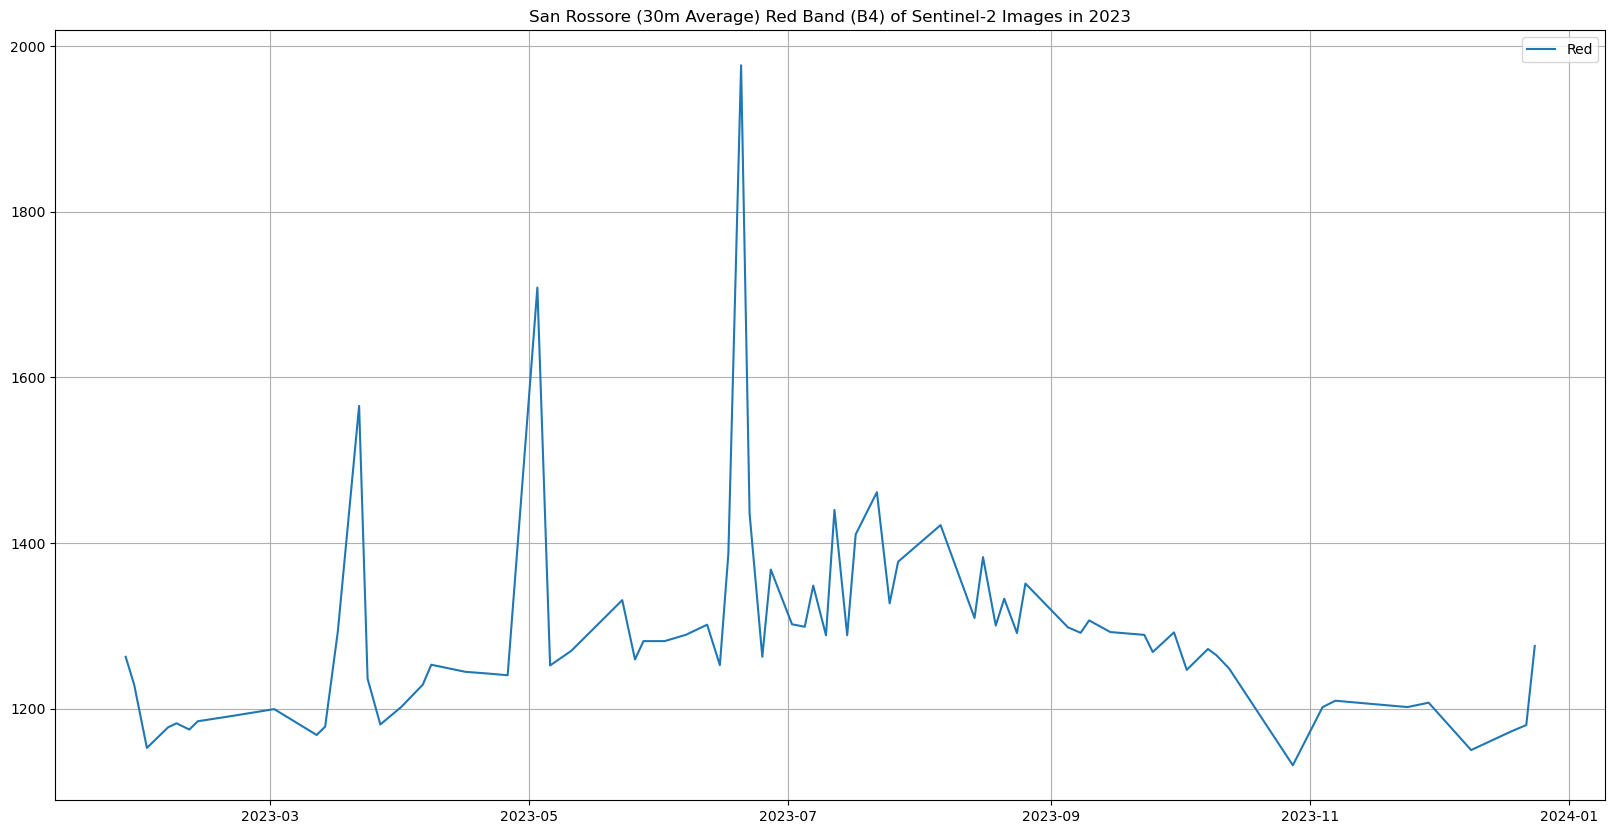

In [33]:
plt.figure(figsize = (20,10))
plt.title("San Rossore (30m Average) Red Band (B4) of Sentinel-2 Images in 2023")
plt.plot(df_Merge_Mean['datetime'], df_Merge_Mean['B4'], label = "Red")
plt.legend()
plt.grid()

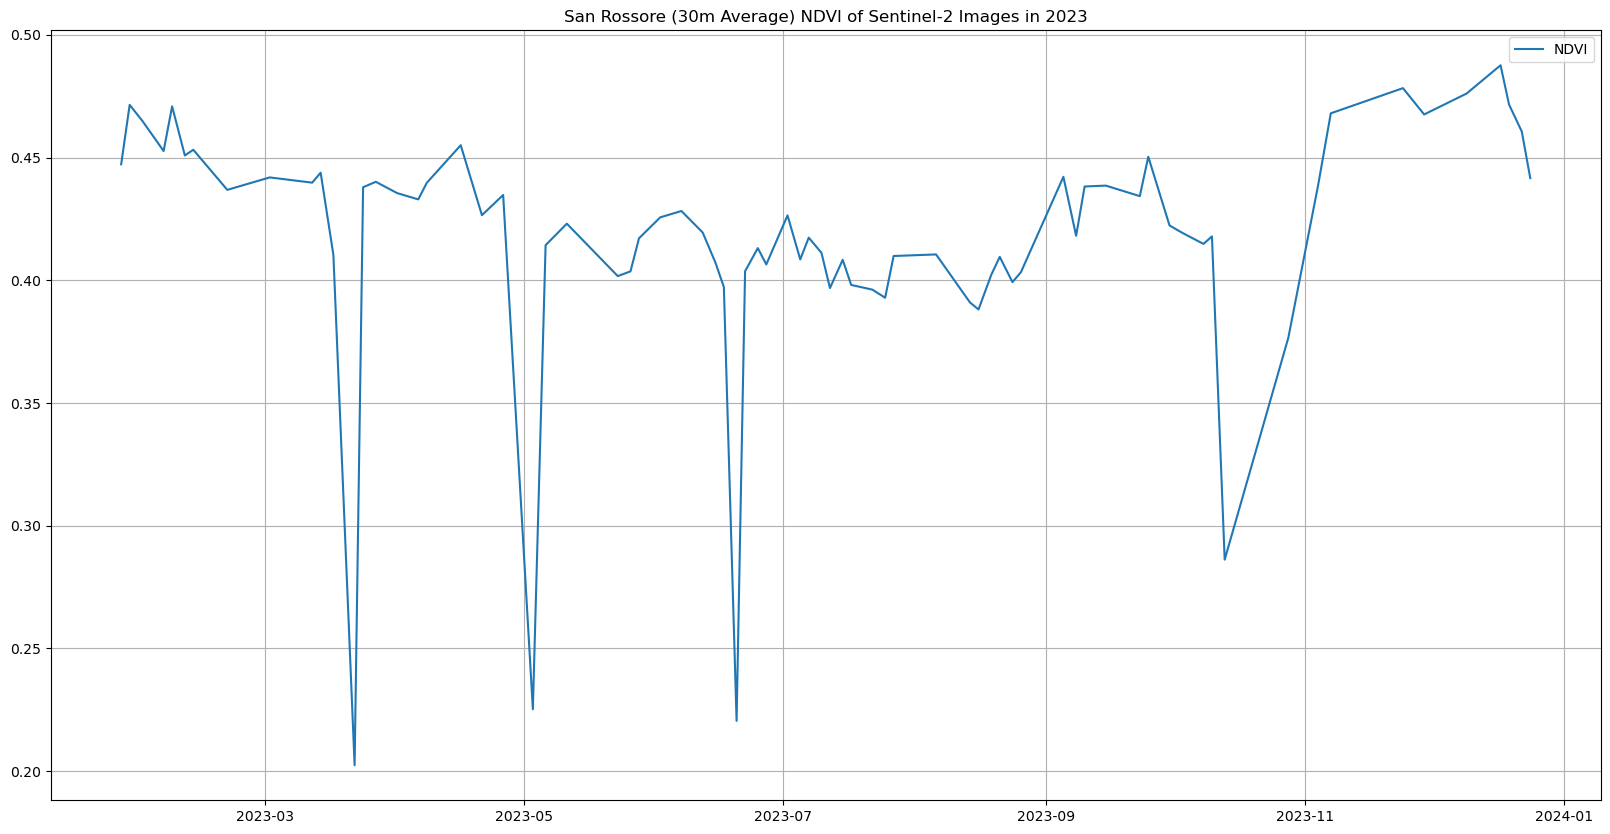

In [34]:
plt.figure(figsize = (20,10))
plt.title("San Rossore (30m Average) NDVI of Sentinel-2 Images in 2023")
plt.plot(df_Merge_Mean['datetime'], df_Merge_Mean['NDVI'], label = "NDVI")
plt.legend()
plt.grid()